# TabNet: Attentive Interpretable Tabular Learning

## Preparation

In [ ]:
%%capture
!pip install pytorch-tabnet
!pip install imblearn
!pip install catboost
!pip install tab-transformer-pytorch

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix

from imblearn.metrics import sensitivity_score,specificity_score,sensitivity_specificity_support

import pandas as pd
import numpy as np
import pprint

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetClassifier
from tab_transformer_pytorch import TabTransformer;

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

## Preprocessing

Cover type dataset contains tree observations from four areas of the Roosevelt National Forest in Colorado. All observations are cartographic variables (no remote sensing) from 30 meter x 30 meter sections of forest. There are over half a million measurements total! This dataset includes information on tree type, shadow coverage, distance to nearby landmarks (roads etcetera), soil type, and local topography.

Class descriptions:

* **1:** Spruce/Fir
* **2:** Lodgepole Pine
* **3:** Ponderosa Pine
* **4:** Cottonwood/Willow
* **5:** Aspen
* **6:** Douglas-fir
* **7:** Krummholz

For more details for dataset, please see metadata from [this link](https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/).

In [ ]:
base_data_path = "/content/drive/MyDrive/applied_ai_enes_safak/datasets/"
forest_cover_type_dataset = base_data_path + "cover_type.csv"

data = pd.read_csv(forest_cover_type_dataset)

In [ ]:
df_train = data.iloc[:11_340,:]
df_val = data.iloc[11_340:11_340+3_780,:]
df_test = data.iloc[11_340+3_780:, :]

In [ ]:
print(len(df_train),len(df_val),len(df_test))

11340 3780 565892


In [ ]:
pprint.saferepr(data.columns.to_list())

"['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']"

In [ ]:
data['Cover_Type'].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

In [ ]:
X_train, y_train = df_train.iloc[:,:-1].values, df_train.iloc[:,-1].values
X_val, y_val = df_val.iloc[:,:-1].values, df_val.iloc[:,-1].values
X_test, y_test = df_test.iloc[:,:-1].values, df_test.iloc[:,-1].values

## Modeling TabNet

In [ ]:
from pytorch_tabnet.metrics import Metric
class GMean(Metric):
  def __init__(self):
    self._name = "gmean"
    self._maximize = True
  
  def __call__(self, y_true, y_pred):
    return np.sqrt(sensitivity_score(y_true, y_pred, average="macro"), specificity_score(y_true, y_pred, average="macro"))

In [ ]:
clf = TabNetClassifier(
    lambda_sparse = 1e-4,
    n_d = 64,
    n_a = 64,
    gamma = 1.5,
    optimizer_params=dict(lr=0.02),
    scheduler_params={"gamma":0.95, "verbose":0, "step_size":15},
    #scheduler_fn = torch.optim.lr_scheduler.ExponentialLR,
    scheduler_fn = torch.optim.lr_scheduler.StepLR,
    #optimizer_fn = torch.optim.AdamW
    optimizer_fn = torch.optim.Adam,
)

Device used : cuda


In [ ]:
clf.fit(
    X_train = X_train,
    y_train = y_train,
    eval_set = [(X_val, y_val)],
    max_epochs = 1000,
    batch_size = 1024,
    virtual_batch_size = 128,
    num_workers = 0,
    patience = 20,
    drop_last = False,
    eval_metric=['balanced_accuracy']
)

# more for batching strategies: https://arxiv.org/pdf/1906.03548.pdf

epoch 0  | loss: 1.68201 | val_0_balanced_accuracy: 0.13069 |  0:00:00s
epoch 1  | loss: 0.99313 | val_0_balanced_accuracy: 0.13571 |  0:00:00s
epoch 2  | loss: 0.8866  | val_0_balanced_accuracy: 0.14233 |  0:00:01s
epoch 3  | loss: 0.84699 | val_0_balanced_accuracy: 0.14286 |  0:00:01s
epoch 4  | loss: 0.80639 | val_0_balanced_accuracy: 0.14286 |  0:00:02s
epoch 5  | loss: 0.77342 | val_0_balanced_accuracy: 0.14153 |  0:00:02s
epoch 6  | loss: 0.78371 | val_0_balanced_accuracy: 0.14392 |  0:00:03s
epoch 7  | loss: 0.77851 | val_0_balanced_accuracy: 0.14418 |  0:00:03s
epoch 8  | loss: 0.75601 | val_0_balanced_accuracy: 0.14365 |  0:00:04s
epoch 9  | loss: 0.72842 | val_0_balanced_accuracy: 0.14683 |  0:00:04s
epoch 10 | loss: 0.73169 | val_0_balanced_accuracy: 0.15582 |  0:00:05s
epoch 11 | loss: 0.735   | val_0_balanced_accuracy: 0.17328 |  0:00:05s
epoch 12 | loss: 0.71831 | val_0_balanced_accuracy: 0.18624 |  0:00:06s
epoch 13 | loss: 0.69209 | val_0_balanced_accuracy: 0.19471 |  0

In [ ]:
clf.history

{'loss': [1.682010163453521, 0.9931275494725196, 0.8865977325767437, 0.8469881947919384, 0.8063921624180291, 0.7734205762124776, 0.78370681559598, 0.7785077228537732, 0.7560079034674104, 0.7284201265642882, 0.731690090442671, 0.7349997008498593, 0.7183084979048903, 0.6920879300098991, 0.6840237812390403, 0.6841735542135895, 0.6762004228916538, 0.6810150512732316, 0.6855395653050202, 0.729816140741688, 0.7219260029902114, 0.7196490972340632, 0.7106048817567304, 0.6845005153768697, 0.6641512994413022, 0.6706452113820972, 0.6827604188279921, 0.669838408313731, 0.7093854667858682, 0.6793098835087327, 0.6599170014130796, 0.6320277392128367, 0.6255310833769501, 0.6292558444450351, 0.6091215204730025, 0.6080036089744096, 0.5986264270659688, 0.593610049282222, 0.5953401045403993, 0.569632660753933, 0.5683842908242812, 0.5641822112510654, 0.5541646418537833, 0.5894453504939138, 0.5796066729479996, 0.5610276235684726, 0.542540856034247, 0.5424980822694365, 0.5371926705042521, 0.5479667002772107,

In [ ]:
y_preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
f1 = f1_score(y_test, y_preds, average="macro")
print(f"Accuracy: {accuracy}\nROC-AUC: {roc_auc}")

Accuracy: 0.7015490588310137
ROC-AUC: 0.9505092037247387


## CatBoost Comparison

In [ ]:
catboost = CatBoostClassifier(verbose=0) 
catboost.fit(X_train, y_train)

y_preds = catboost.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, catboost.predict_proba(X_test), multi_class='ovr')
f1 = f1_score(y_test, y_preds, average="macro")
print(f"Catboost Accuracy: {accuracy}\nCatboost ROC-AUC: {roc_auc}")

Catboost Accuracy: 0.723685791635153
Catboost ROC-AUC: 0.9604494980569805


## Explainable TabNet

In [ ]:
clf.feature_importances_

array([2.21885300e-01, 5.62143748e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.15307947e-02, 1.12806866e-02, 9.44496728e-03,
       1.69580841e-06, 2.48604087e-02, 3.43196964e-02, 0.00000000e+00,
       0.00000000e+00, 2.40914036e-01, 0.00000000e+00, 7.08053450e-03,
       1.25902705e-02, 0.00000000e+00, 1.44919480e-02, 1.39460668e-02,
       0.00000000e+00, 1.46982905e-04, 3.86808646e-02, 6.12716889e-02,
       3.40065982e-03, 6.79061625e-06, 3.99564845e-02, 2.09382035e-02,
       2.42823729e-02, 0.00000000e+00, 8.84775260e-03, 9.47845876e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.87680836e-06, 3.02454100e-02, 0.00000000e+00,
       8.78658529e-04, 2.18933153e-06, 4.73703973e-02, 1.39294116e-02,
       0.00000000e+00, 0.00000000e+00, 1.51779698e-02, 1.69791784e-03,
       1.31315720e-02, 0.00000000e+00, 0.00000000e+00, 2.50102922e-02,
       0.00000000e+00, 2.75762020e-02])

In [ ]:
explain_matrix, masks = clf.explain(X_test)

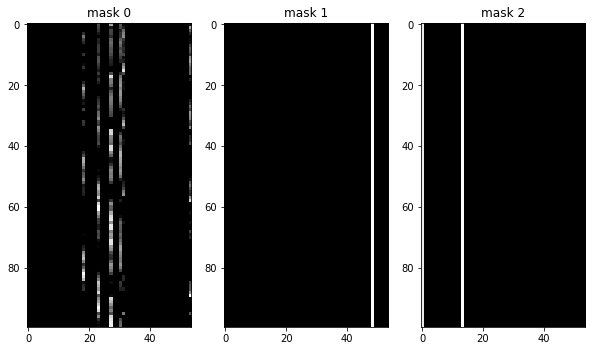

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))
for i in range(len(masks)):
  axs[i].imshow(masks[i][:100],cmap="gray")
  axs[i].set_title(f"mask {i}")

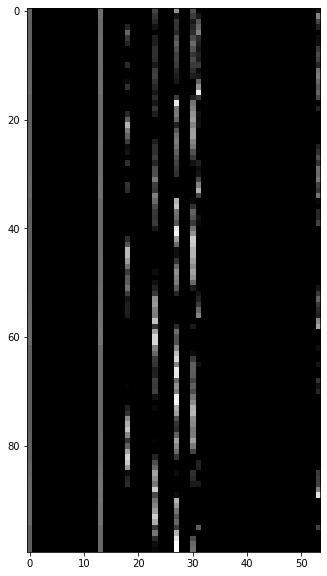

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow(explain_matrix[:100],cmap="gray")

## Highly Imbalanced Dataset: Seismic Bumps

Seismic hazard is the hardest detectable and predictable of natural hazards and in
this respect it is comparable to an earthquake. More and more advanced seismic and seismoacoustic
monitoring systems allow a better understanding rock mass processes and definition of seismic hazard
prediction methods. Accuracy of so far created methods is however far from perfect. Good prediction
of increased seismic activity is therefore a matter of great practical importance. The presented data
set is characterized by unbalanced distribution of positive and negative examples. In the data set there
are only 170 positive examples representing class 1.

In [ ]:
def gmean(y_true, y_pred):
    return np.sqrt(sensitivity_score(y_true, y_pred) * specificity_score(y_true,y_pred))

In [ ]:
subsample = 300

base_data_path = "/content/drive/MyDrive/applied_ai_enes_safak/datasets/"
forest_cover_type_dataset = base_data_path + "seismic_bumps.csv"

data = pd.read_csv(forest_cover_type_dataset).drop(["id"],axis=1)
data_wo_0 = data[data["class"] != 0]
data_w0_undersampled = data[data["class"] == 0].sample(subsample).reset_index(drop=True)

data_c = pd.concat([data_wo_0, data_w0_undersampled],axis=0).sample(frac=1).reset_index(drop=True)

In [ ]:
data_c["class"].value_counts()

0    300
1    170
Name: class, dtype: int64

In [ ]:
cont_cols = data_c.drop(["class"],axis=1)._get_numeric_data().columns
cat_cols = list(set(data_c.drop(["class"],axis=1).columns) - set(cont_cols))

data_c["seismic"] = data_c["seismic"].factorize()[0]
data_c["seismoacoustic"] = data_c["seismoacoustic"].factorize()[0]
data_c["shift"] = data_c["shift"].factorize()[0]
data_c["ghazard"] = data_c["ghazard"].factorize()[0]

cat_cols_idx = [data_c.columns.to_list().index(i) for i in cat_cols]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_c.iloc[:,:-1].values,data_c.iloc[:,-1].values,test_size = 0.33)

In [ ]:
len_unique_cat = [len(np.unique(X_train[:,data.columns.to_list().index(i)])) for i in cat_cols]

In [ ]:
clf = TabNetClassifier(
    lambda_sparse = 1e-2,
    n_d = 8,
    n_a = 8,
    gamma = 1.5,
    optimizer_params=dict(lr=0.05),
    scheduler_params={"gamma":0.95, "verbose":0, "step_size":15},
    #scheduler_fn = torch.optim.lr_scheduler.ExponentialLR,
    scheduler_fn = torch.optim.lr_scheduler.StepLR,
    #optimizer_fn = torch.optim.AdamW
    optimizer_fn = torch.optim.Adam,
    cat_idxs = cat_cols_idx,
    cat_dims = len_unique_cat
)

Device used : cuda


In [ ]:
clf.fit(
    X_train = X_train,
    y_train = y_train,
    eval_set = [(X_test, y_test)],
    max_epochs = 1000,
    batch_size = 1024,
    virtual_batch_size = 128,
    num_workers = 0,
    patience = 20,
    drop_last = False,
    eval_metric=['auc']
)

epoch 0  | loss: 1.07376 | val_0_auc: 0.51923 |  0:00:00s
epoch 1  | loss: 0.72951 | val_0_auc: 0.50119 |  0:00:00s
epoch 2  | loss: 0.67269 | val_0_auc: 0.51218 |  0:00:00s
epoch 3  | loss: 0.68094 | val_0_auc: 0.49057 |  0:00:00s
epoch 4  | loss: 0.61045 | val_0_auc: 0.53206 |  0:00:00s
epoch 5  | loss: 0.60235 | val_0_auc: 0.56778 |  0:00:00s
epoch 6  | loss: 0.57507 | val_0_auc: 0.61467 |  0:00:00s
epoch 7  | loss: 0.60057 | val_0_auc: 0.65241 |  0:00:00s
epoch 8  | loss: 0.55924 | val_0_auc: 0.62685 |  0:00:00s
epoch 9  | loss: 0.56227 | val_0_auc: 0.61403 |  0:00:00s
epoch 10 | loss: 0.58121 | val_0_auc: 0.61944 |  0:00:00s
epoch 11 | loss: 0.54583 | val_0_auc: 0.61742 |  0:00:00s
epoch 12 | loss: 0.56463 | val_0_auc: 0.62979 |  0:00:00s
epoch 13 | loss: 0.58659 | val_0_auc: 0.64545 |  0:00:00s
epoch 14 | loss: 0.56752 | val_0_auc: 0.58161 |  0:00:00s
epoch 15 | loss: 0.5617  | val_0_auc: 0.55514 |  0:00:00s
epoch 16 | loss: 0.53297 | val_0_auc: 0.55752 |  0:00:00s
epoch 17 | los

In [ ]:
proba = clf.predict_proba(X_test)
proba_unhot = []
for row in proba:
  proba_unhot.append(row[1])

In [ ]:
y_preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, proba_unhot)
print(f"Accuracy: {accuracy}\nROC-AUC: {roc_auc}")

Accuracy: 0.7115384615384616
ROC-AUC: 0.7490382854002564


In [ ]:
gmean(y_test, y_preds)

0.7172028465244906

In [ ]:
confusion_matrix(y_test, y_preds)

array([[72, 31],
       [14, 39]])

In [ ]:
proba = catboost.predict_proba(X_test)
proba_unhot = []
for row in proba:
  proba_unhot.append(row[1])

catboost = CatBoostClassifier(verbose=0) 
catboost.fit(X_train, y_train)

y_preds = catboost.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, proba_unhot)
print(f"Catboost Accuracy: {accuracy}\nCatboost ROC-AUC: {roc_auc}")

Catboost Accuracy: 0.7051282051282052
Catboost ROC-AUC: 0.8613299139036453


In [ ]:
confusion_matrix(y_test, y_preds)

array([[89, 14],
       [32, 21]])

In [ ]:
gmean(y_test, y_preds)

0.585124258178296

In [ ]:
explain_matrix, masks = clf.explain(X_test)

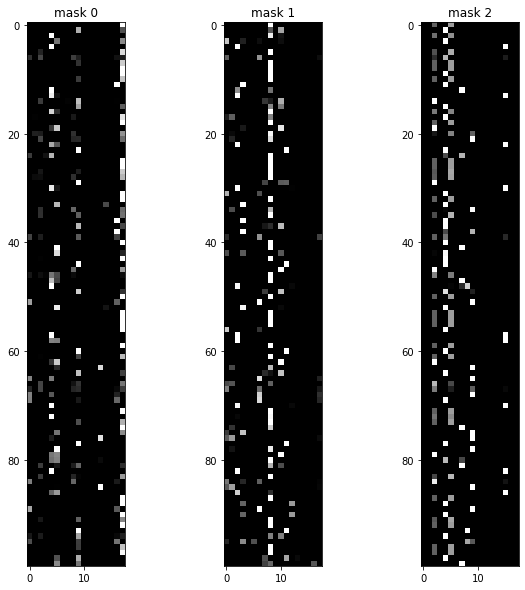

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))
for i in range(len(masks)):
  axs[i].imshow(masks[i][:100],cmap="gray")
  axs[i].set_title(f"mask {i}")

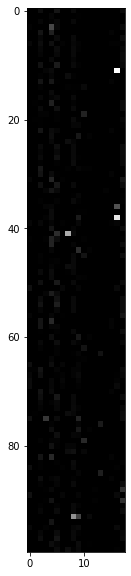

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow(explain_matrix[:100],cmap="gray")